<a href="https://colab.research.google.com/github/chitra-psg/rossmann_sales_prediction/blob/main/Rossman_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
#importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [104]:
store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [105]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [106]:
#Check nulls for null treatment
store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [107]:
#Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
store.Promo2.value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [108]:
#CompetitionDistance - describes thedistance in meters to the nearest competitor store
store[store['CompetitionDistance'].isna()]
#Competition Distance not available would indicate no competitor

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [109]:
#NULL Treatment
#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
#PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew.
#E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].replace(np.nan,0).astype(int)
store['Promo2SinceYear'] = store['Promo2SinceYear'].replace(np.nan,0).astype(int)
store['PromoInterval'] = store['PromoInterval'].replace(np.nan,0)

#CompetitionDistance - describes the distance in meters to the nearest competitor store
#CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

store['CompetitionDistance'] = store['CompetitionDistance'].replace(np.nan,0).astype(int)
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].mode()[0]).astype(int)
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].mode()[0]).astype(int)

In [110]:

store[store['CompetitionDistance']==0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,0,9,2013,0,0,0,0
621,622,a,c,0,9,2013,0,0,0,0
878,879,d,a,0,9,2013,1,5,2013,"Feb,May,Aug,Nov"


In [111]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,0,0,0
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,0,0,0
4,5,a,a,29910,4,2015,0,0,0,0


In [112]:
# Doing competition month and year = 0
store.loc[store.CompetitionDistance==0, 'CompetitionOpenSinceMonth'] = 0
store.loc[store.CompetitionDistance==0, 'CompetitionOpenSinceYear'] = 0

In [113]:

store[store['CompetitionDistance']==0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,0,0,0,0,0,0,0
621,622,a,c,0,0,0,0,0,0,0
878,879,d,a,0,0,0,1,5,2013,"Feb,May,Aug,Nov"


In [114]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

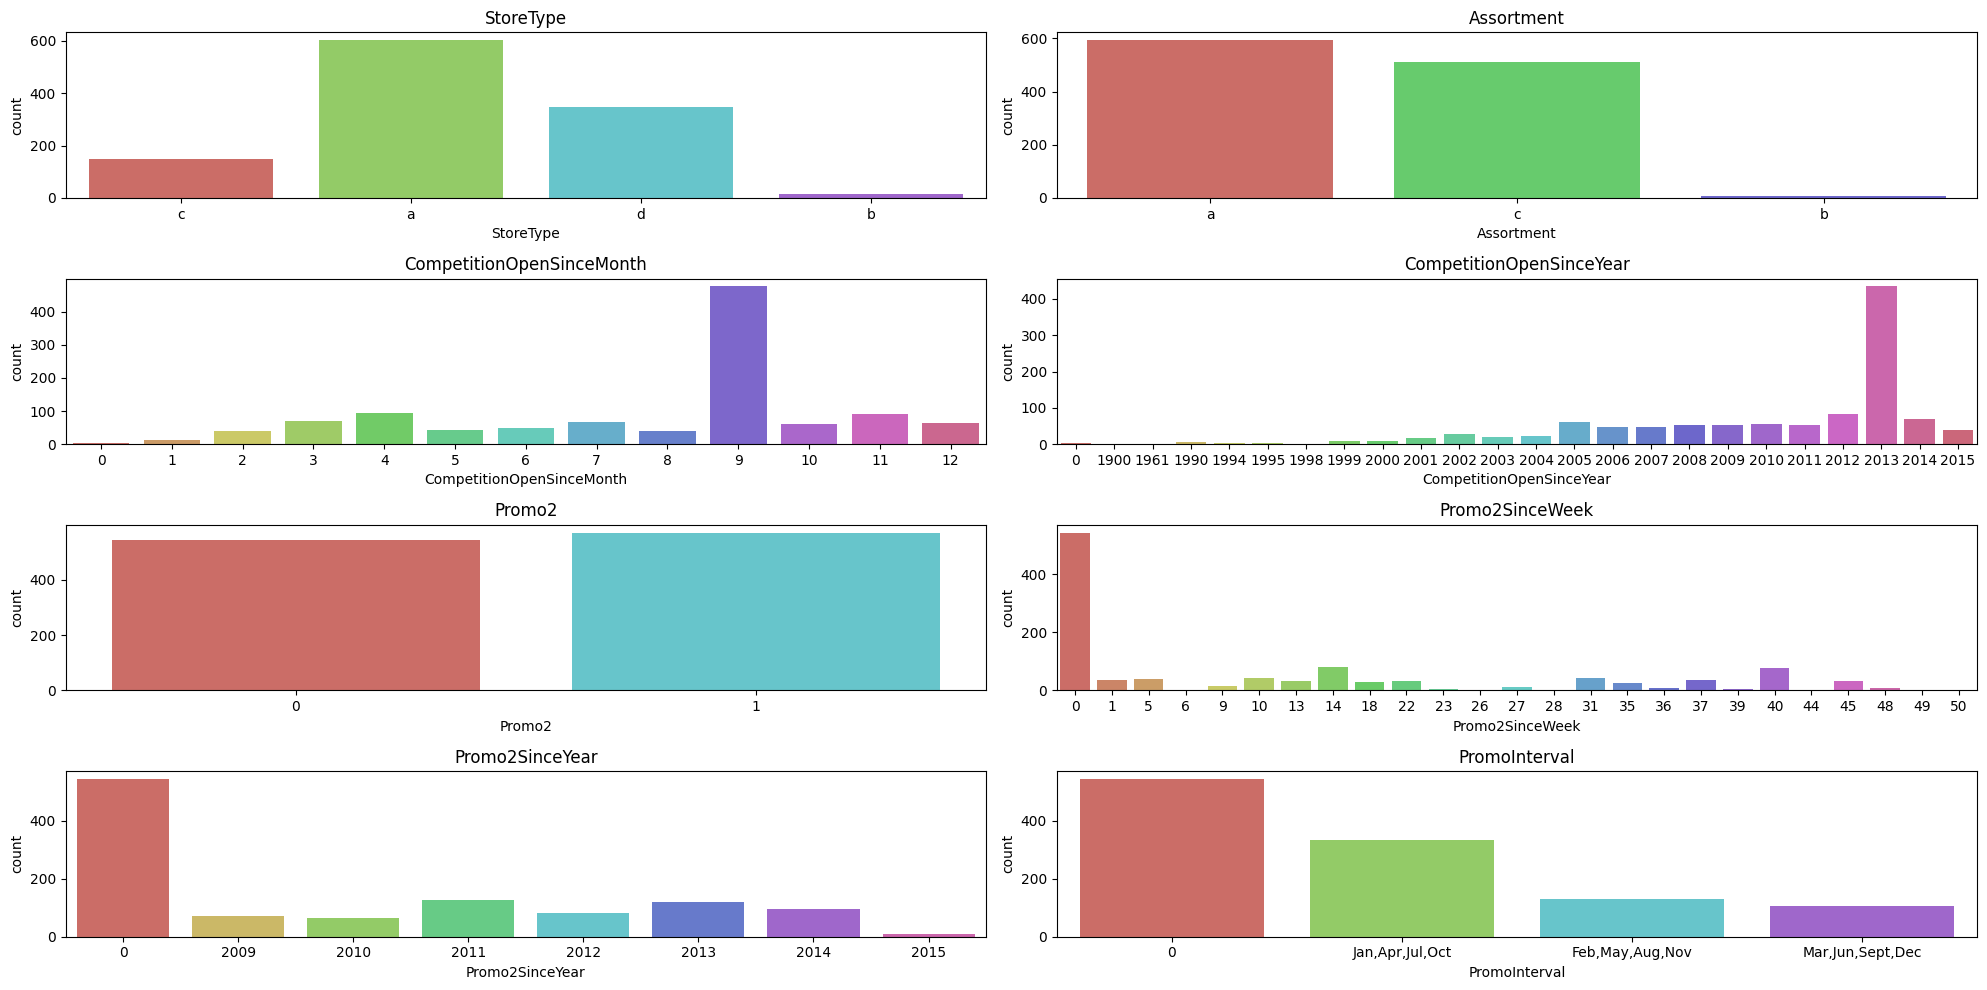

In [115]:
# Select categorical columns
categorical_cols = ['StoreType', 'Assortment','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']#Excluding Store

# Define rows and columns for subplots
rows = int(np.ceil(len(categorical_cols) / 2))  # Assuming 3 columns per row
cols = min(2, len(categorical_cols))

# Create figure and subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 10), squeeze=True)  # Ensure 1D array of subplots

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=store, ax=axs.ravel()[i], palette="hls")
    axs.ravel()[i].set_title(col)
    axs.ravel()[i].xaxis.set_label_text(col)  # Access and set label on the correct subplot's axis

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()


**Inferences**
> Maximum competitions are opened in the month of september or 9

> Maximum competitiors opened their store in the year 2013

> 48% stores don't have promo2

> StoreType = a is maximum among others

> Majority of assortments are 'a'





In [116]:
train = pd.read_csv('train.csv')
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [118]:
# Convert Date to a date-time-object
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')

#train = train.set_index('Date')

In [119]:
train.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [120]:
train.StateHoliday = train.StateHoliday.replace('0',0)

In [121]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [122]:
train.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [123]:
train_open = train[train.Open==1]
train_open.shape

(844392, 9)

In [124]:
train_open.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [125]:
train_open.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

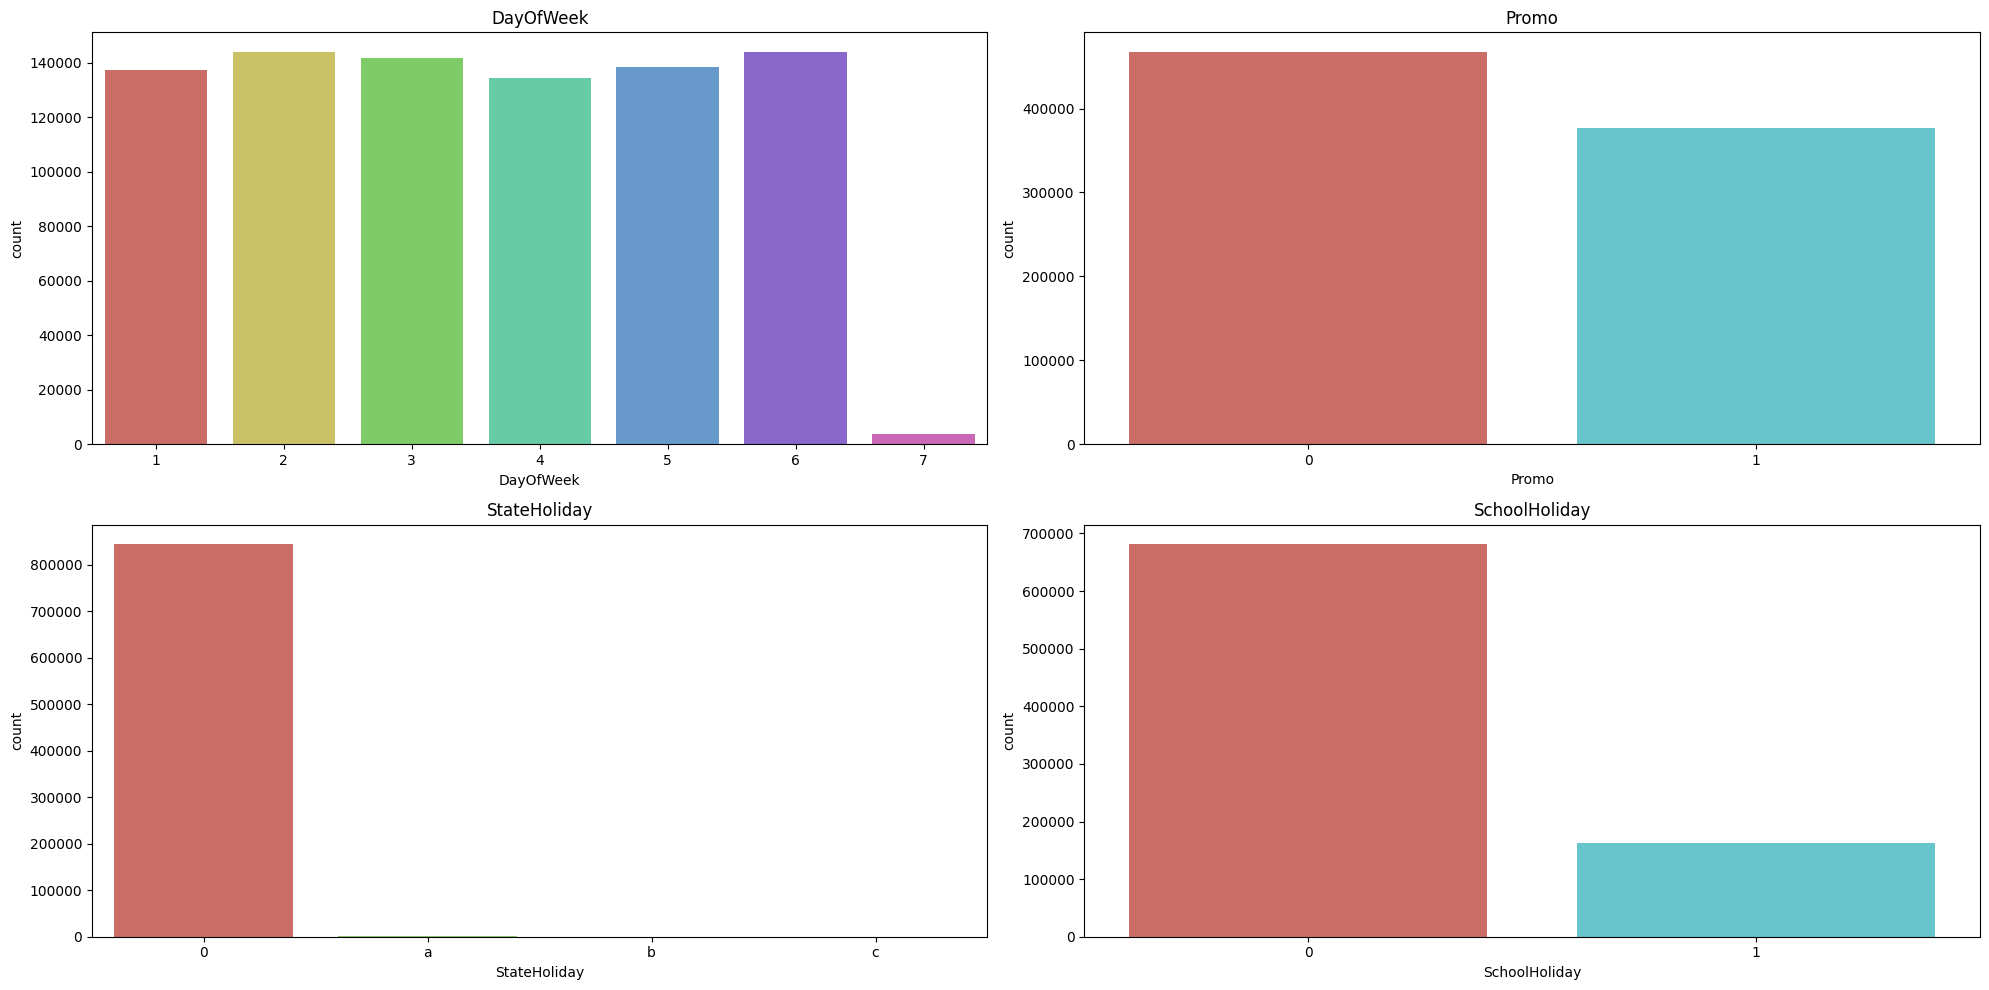

In [126]:
# Select categorical columns
train_categorical_cols = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday']

# Define rows and columns for subplots
rows = int(np.ceil(len(train_categorical_cols) / 2))  # Assuming 3 columns per row
cols = min(2, len(train_categorical_cols))

# Create figure and subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 10), squeeze=True)  # Ensure 1D array of subplots

for i, col in enumerate(train_categorical_cols):
    sns.countplot(x=col, data=train_open, ax=axs.ravel()[i], palette="hls")
    axs.ravel()[i].set_title(col)
    axs.ravel()[i].xaxis.set_label_text(col)  # Access and set label on the correct subplot's axis

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

**Inferences**
*   All days of the week have almost equal sales
*   Mostly the store is open
*   Promotions are less active

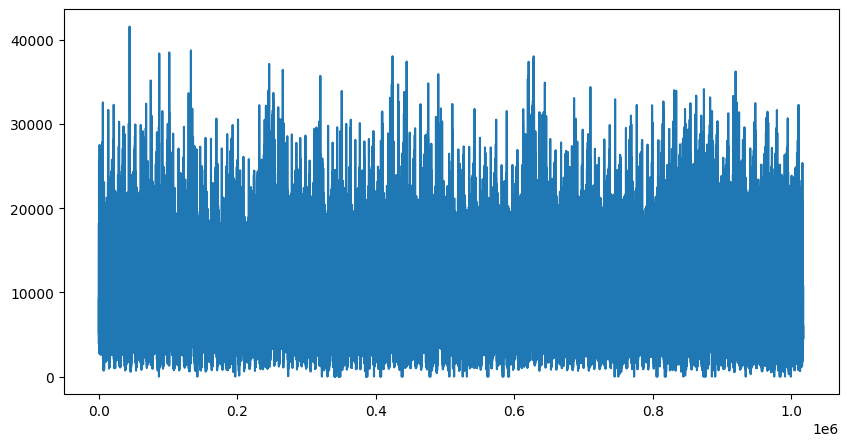

In [127]:
# sales plot
train_open.Sales.plot(figsize=(10,5))
plt.show()

In [128]:
# detecting outliers
train_open.describe(percentiles=[0.90,0.95,0.99,0.01])

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.0,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,1.0,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.0,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000
1%,11.000000,1.000000,2185.000000,250.000000,1.0,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000
90%,1004.000000,6.000000,10771.000000,1177.000000,1.0,1.000000,1.000000
95%,1060.000000,6.000000,12668.000000,1440.000000,1.0,1.000000,1.000000
99%,1104.000000,6.000000,17789.000000,2415.000000,1.0,1.000000,1.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000


In [129]:

# Calculate the 99th percentile of sales
sales_higher_threshold = train_open.Sales.quantile(0.99)
sales_lower_threshold = train_open.Sales.quantile(0.01)

# Filter the dataframe to remove outliers
train_open = train_open[(train_open.Sales <= sales_higher_threshold) & (train_open.Sales >= sales_lower_threshold)]


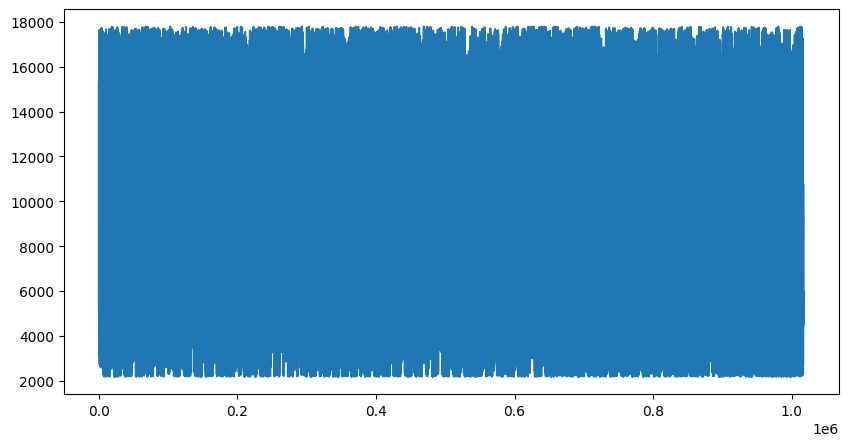

In [130]:
# sales plot
train_open.Sales.plot(figsize=(10,5))
plt.show()

In [131]:
# Check for ZERO values in Sales or Customer Values
count = (train_open['Sales'] == 0).sum()
print('Number of zero values in Sales column:', count)

Number of zero values in Sales column: 0


In [132]:
# Check for ZERO values in Customer Values
count = (train_open['Customers'] == 0).sum()
print('Number of zero values in Customers column:', count)

Number of zero values in Customers column: 0


In [133]:
# Check for null value rows and columns
missing = train_open.isnull().sum()
missing.sort_values(ascending=False)

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [134]:
store_sales = train.merge(right=store, on='Store', how='left')

In [135]:
store_sales.shape

(1017209, 18)

In [136]:
filtered_store_sales = store_sales[
        (store_sales.Store == 1) | (store_sales.Store == 3)| (store_sales.Store == 8)| (store_sales.Store == 9)| (store_sales.Store == 13) |
        (store_sales.Store == 25) | (store_sales.Store == 29)| (store_sales.Store == 31)| (store_sales.Store == 46)
     ]

In [137]:
# DELETE rows where Sales == 0 and Open == 0
# Open - an indicator for whether the store was open: 0 = closed, 1 = open
filtered_store_sales = filtered_store_sales[~((filtered_store_sales.Open==0) & (filtered_store_sales.Sales==0))]

In [138]:
# Now that we have filetred this let us see if there are any other anamolies
count = ((filtered_store_sales.Open==1) & (filtered_store_sales.Sales==0)).sum()
print(count)

2


In [139]:
filtered_store_sales[((filtered_store_sales.Open==1) & (filtered_store_sales.Sales==0))]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
561199,25,4,2014-02-13,0,0,1,0,0,0,c,a,430,4,2003,0,0,0,0
562314,25,3,2014-02-12,0,0,1,0,0,0,c,a,430,4,2003,0,0,0,0


In [140]:
# Update the above two rows's Sales and Customer to NaN and linear interpolate
filtered_store_sales.loc[((filtered_store_sales.Open==1) & (filtered_store_sales.Sales==0)), 'Sales'] = np.nan
filtered_store_sales.loc[((filtered_store_sales.Open==1) & (filtered_store_sales.Customers==0)), 'Customers'] = np.nan

In [141]:
filtered_store_sales.loc[((filtered_store_sales.Date=='2014-02-13') & (filtered_store_sales.Store==25))]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
561199,25,4,2014-02-13,NaN,NaN,1,0,0,0,c,a,430,4,2003,0,0,0,0


In [142]:
filtered_df = filtered_store_sales.set_index('Date')
#Extracting some date features for analysis for all stores.
filtered_df['Year'] = filtered_df.index.year
filtered_df['Month'] = filtered_df.index.month
filtered_df['Day'] = filtered_df.index.day
filtered_df['WeekOfYear'] = filtered_df.index.weekofyear

Only nine stores have to be considered so let us filter those.
Since the company is just embarking on this project, the scope has been kept to nine key stores across Europe. The stores are key for the company keeping in mind the revenue and historical prestige associated with them. These stores are numbered - 1,3,8,9,13,25,29,31 and 46

In [143]:
data_store1 = filtered_df[(filtered_df.Store==1)]
print('Number of records for store 1: ', len(data_store1))
data_store3 = filtered_df[(filtered_df.Store==3)]
print('Number of records for store 3: ', len(data_store3))
data_store8 = filtered_df[(filtered_df.Store==8)]
print('Number of records for store 8: ', len(data_store8))
data_store9 = filtered_df[(filtered_df.Store==9)]
print('Number of records for store 9: ', len(data_store9))
#
data_store13 = filtered_df[(filtered_df.Store==13)]
print('Number of records for store 13: ', len(data_store13))
data_store25 = filtered_df[(filtered_df.Store==25)]
print('Number of records for store 25: ', len(data_store25))
data_store29 = filtered_df[(filtered_df.Store==29)]
print('Number of records for store 29: ', len(data_store29))
data_store31 = filtered_df[(filtered_df.Store==31)]
print('Number of records for store 31: ', len(data_store31))
#
data_store46 = filtered_df[(filtered_df.Store==46)]
print('Number of records for store 46: ', len(data_store46))

Number of records for store 1:  781
Number of records for store 3:  779
Number of records for store 8:  784
Number of records for store 9:  779
Number of records for store 13:  621
Number of records for store 25:  752
Number of records for store 29:  779
Number of records for store 31:  784
Number of records for store 46:  622


In [144]:
# seaborn sub-plots parameters
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.8   # the amount of height reserved for white space between subplots

store_dfs = [data_store1, data_store3, data_store8, data_store9, data_store13, data_store25,
                data_store29, data_store31, data_store46
            ]

label_dfs = ['store1', 'store3', 'store8', 'store9', 'store13', 'store25',
                'store29', 'store31', 'store46'
            ]

range_dict = {"0":"1", "1":"3", "2":"5"}

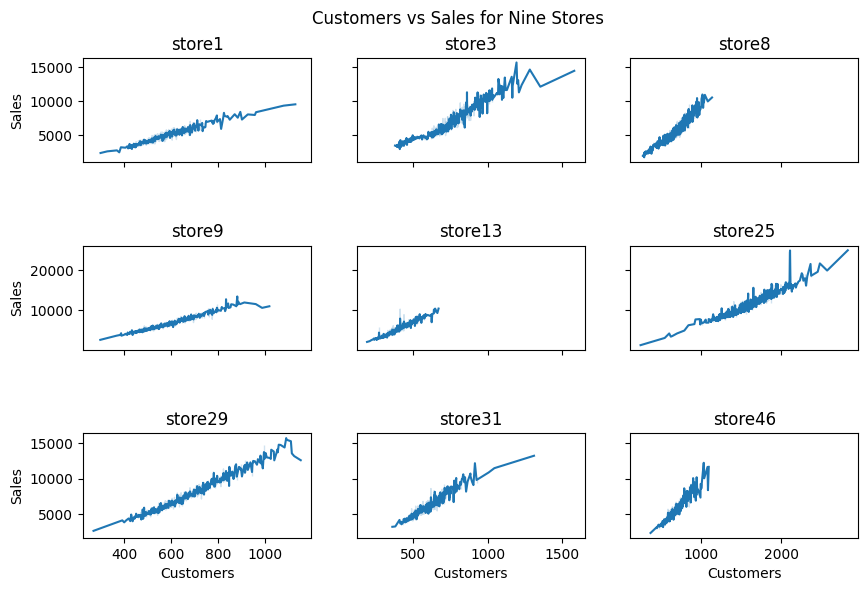

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
# Customers Vs Sales
fig, axis = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(10,6))
fig.suptitle('Customers vs Sales for Nine Stores')
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for x in range (0,3):
    incr = range_dict[str(x)]
    for y in range (0,3):
        i = x + y + int(incr)
        label =  label_dfs[i-1]
        d = store_dfs[i-1]
        #
        axis[x,y].title.set_text(label)
        sns.lineplot(x='Customers', y='Sales', data=d, ax=axis[x,y])